In [3]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')

import optuna
from sklearn.model_selection import cross_validate

import sklearn
import category_encoders
from sklearn import set_config
from sklearn.model_selection import KFold, RandomizedSearchCV, GridSearchCV, train_test_split
import pickle
set_config(transform_output = "pandas")

import optuna.logging
optuna.logging.set_verbosity(optuna.logging.WARNING)
import os


In [4]:
# reading datasets
train_raw = pd.read_csv('data/train.csv')
test_raw = pd.read_csv('data/test.csv')

## Exploratory Data Analysis

In [5]:
train_raw.head()

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,2.0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0
1,3.0,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0
2,4.0,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0
3,5.0,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1.0
4,6.0,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.0,20.0,1.0


In [6]:
train_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440833 entries, 0 to 440832
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CustomerID         440832 non-null  float64
 1   Age                440832 non-null  float64
 2   Gender             440832 non-null  object 
 3   Tenure             440832 non-null  float64
 4   Usage Frequency    440832 non-null  float64
 5   Support Calls      440832 non-null  float64
 6   Payment Delay      440832 non-null  float64
 7   Subscription Type  440832 non-null  object 
 8   Contract Length    440832 non-null  object 
 9   Total Spend        440832 non-null  float64
 10  Last Interaction   440832 non-null  float64
 11  Churn              440832 non-null  float64
dtypes: float64(9), object(3)
memory usage: 40.4+ MB


In [7]:
train_raw.describe(include='all')

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
count,440832.000000,440832.000000,440832,440832.000000,440832.000000,440832.000000,440832.000000,440832,440832,440832.000000,440832.000000,440832.000000
unique,NaN,NaN,2,NaN,NaN,NaN,NaN,3,3,NaN,NaN,NaN
top,NaN,NaN,Male,NaN,NaN,NaN,NaN,Standard,Annual,NaN,NaN,NaN
freq,NaN,NaN,250252,NaN,NaN,NaN,NaN,149128,177198,NaN,NaN,NaN
mean,225398.667955,39.373153,NaN,31.256336,15.807494,3.604437,12.965722,NaN,NaN,631.616223,14.480868,0.567107
std,129531.918550,12.442369,NaN,17.255727,8.586242,3.070218,8.258063,NaN,NaN,240.803001,8.596208,0.495477
min,2.000000,18.000000,NaN,1.000000,1.000000,0.000000,0.000000,NaN,NaN,100.000000,1.000000,0.000000
25%,113621.750000,29.000000,NaN,16.000000,9.000000,1.000000,6.000000,NaN,NaN,480.000000,7.000000,0.000000
50%,226125.500000,39.000000,NaN,32.000000,16.000000,3.000000,12.000000,NaN,NaN,661.000000,14.000000,1.000000
75%,337739.250000,48.000000,NaN,46.000000,23.000000,6.000000,19.000000,NaN,NaN,830.000000,22.000000,1.000000


In [8]:
# checking for missing values
train_raw.isna().sum()

CustomerID           1
Age                  1
Gender               1
Tenure               1
Usage Frequency      1
Support Calls        1
Payment Delay        1
Subscription Type    1
Contract Length      1
Total Spend          1
Last Interaction     1
Churn                1
dtype: int64

In [9]:
# checking for duplicates
train_raw.duplicated().sum()

0

In [10]:
# check whether every customer has only one row of data
train_raw['CustomerID'].value_counts().head(10)

CustomerID
2.0         1
301011.0    1
301009.0    1
301008.0    1
301007.0    1
301006.0    1
301005.0    1
301004.0    1
301003.0    1
301002.0    1
Name: count, dtype: int64

In [11]:
# since customer id is unique for each row, we can drop it
train = train_raw.drop(columns=['CustomerID']).copy()
train = train.dropna().copy()
test = test_raw.drop(columns=['CustomerID']).copy()
test = test.dropna().copy()

In [12]:
# defining categorical and numeric columns
categorical_cols = train.select_dtypes(include='object').columns.to_list()
numeric_cols = train.select_dtypes(include='number').columns.to_list()

In [13]:
# checking for unique values in categorical columns
for col in categorical_cols:
    print(f'{col}')
    print(f'No. of unique: {train[col].nunique()}')
    print(f'Top 10 unique values: {train[col].unique()[:10]}')
    print("="*15)

Gender
No. of unique: 2
Top 10 unique values: ['Female' 'Male']
Subscription Type
No. of unique: 3
Top 10 unique values: ['Standard' 'Basic' 'Premium']
Contract Length
No. of unique: 3
Top 10 unique values: ['Annual' 'Monthly' 'Quarterly']


In [14]:
# checking label balance in the dataset
train['Churn'].value_counts(normalize=True)

Churn
1.0    0.567107
0.0    0.432893
Name: proportion, dtype: float64

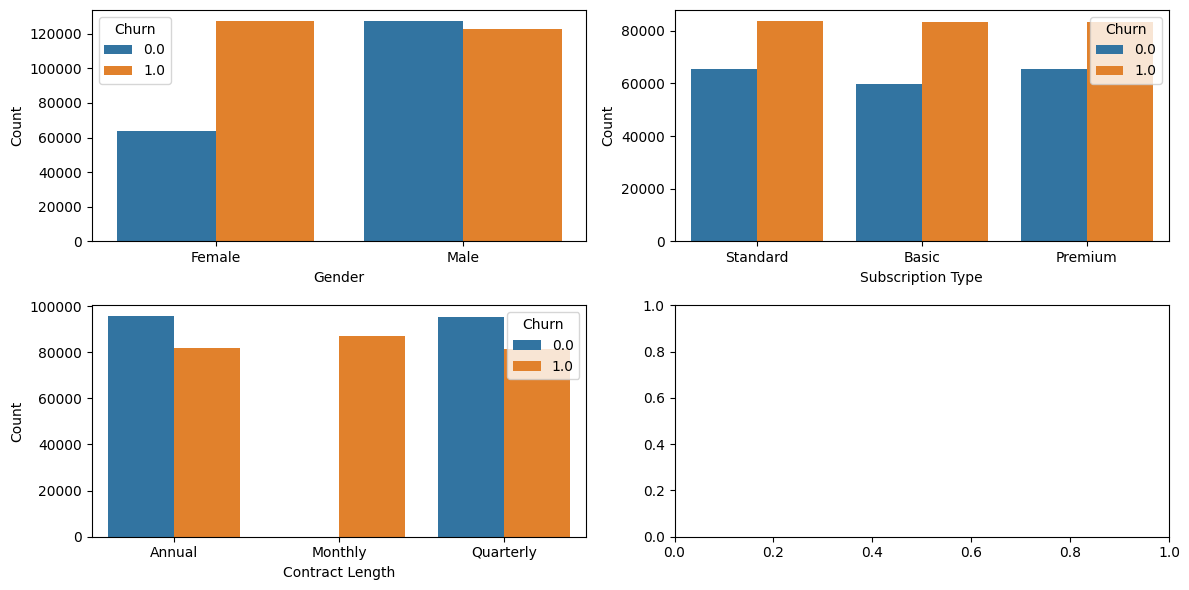

In [15]:
# plotting categorical variables against the target variable
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(len(categorical_cols)//2+len(categorical_cols)%2, 2, figsize=(12, 6 * (len(categorical_cols)//2)))

for i, col in enumerate(categorical_cols):
    sns.countplot(x=col, data=train, hue='Churn', ax=axes[i//2, i%2])
    axes[i//2, i%2].set_xlabel(col)
    axes[i//2, i%2].set_ylabel('Count')
    axes[i//2, i%2].legend(title='Churn')

plt.tight_layout()
plt.show()



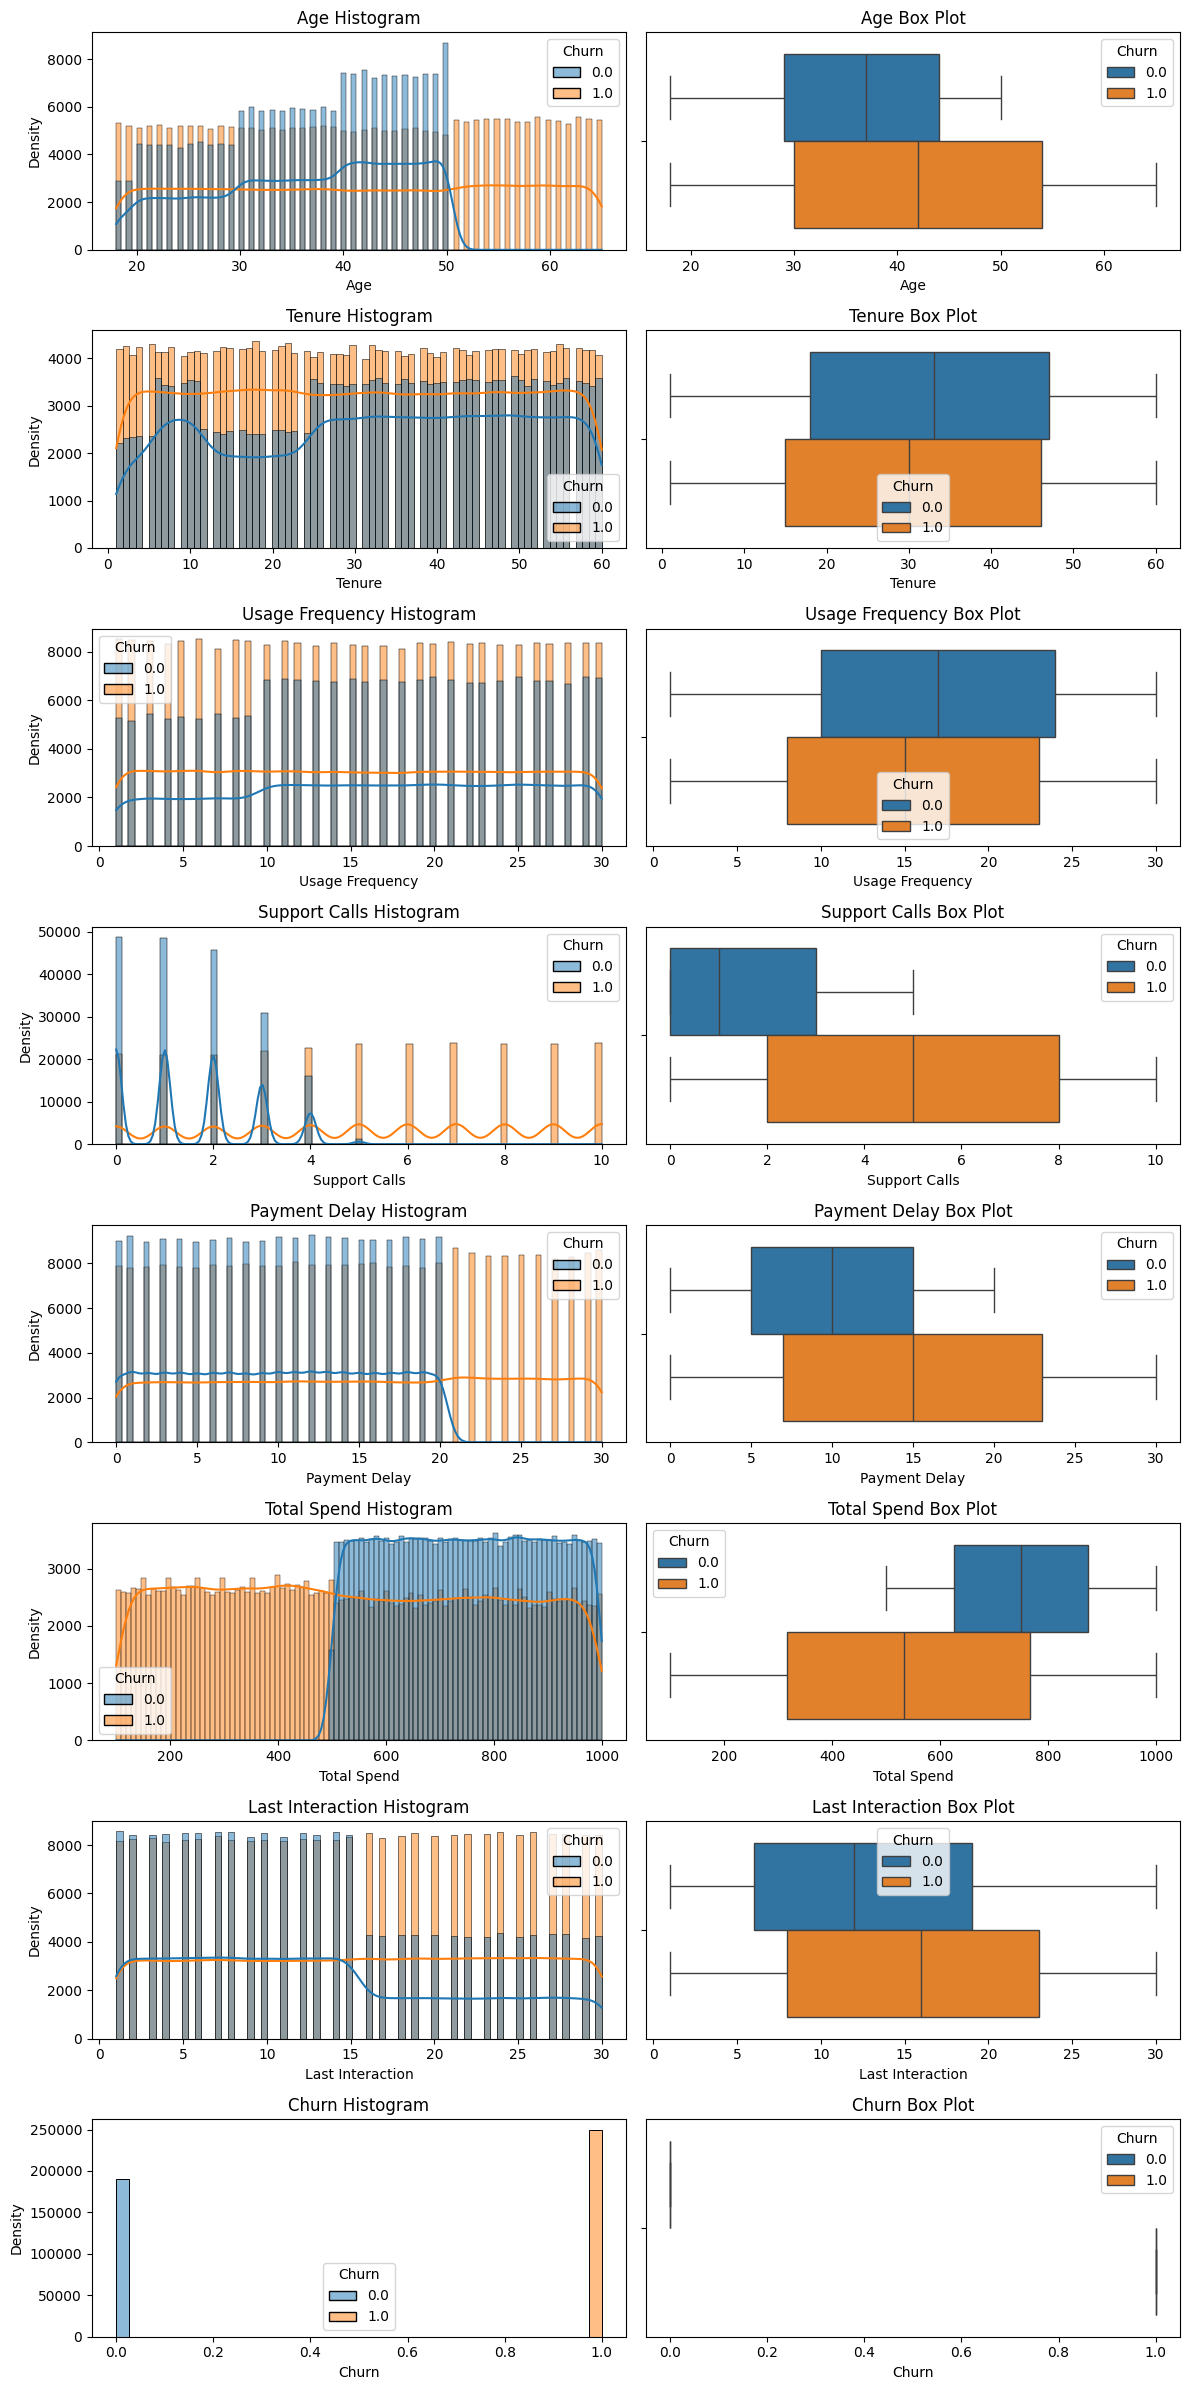

In [16]:
# plotting numeric variables against the target variable
fig, axes = plt.subplots(len(numeric_cols), 2, figsize=(12, 3 * len(numeric_cols)))
for i, col in enumerate(numeric_cols):
    # Histogram with KDE
    sns.histplot(data=train, x=col, kde=True, hue='Churn', ax=axes[i, 0])
    axes[i, 0].set_title(f'{col} Histogram')
    axes[i, 0].set_xlabel(col)
    axes[i, 0].set_ylabel('Density')

    # Box Plot
    sns.boxplot(data=train, x=col, hue='Churn', ax=axes[i, 1])
    axes[i, 1].set_title(f'{col} Box Plot')
    axes[i, 1].set_xlabel(col)

plt.tight_layout()
plt.show()


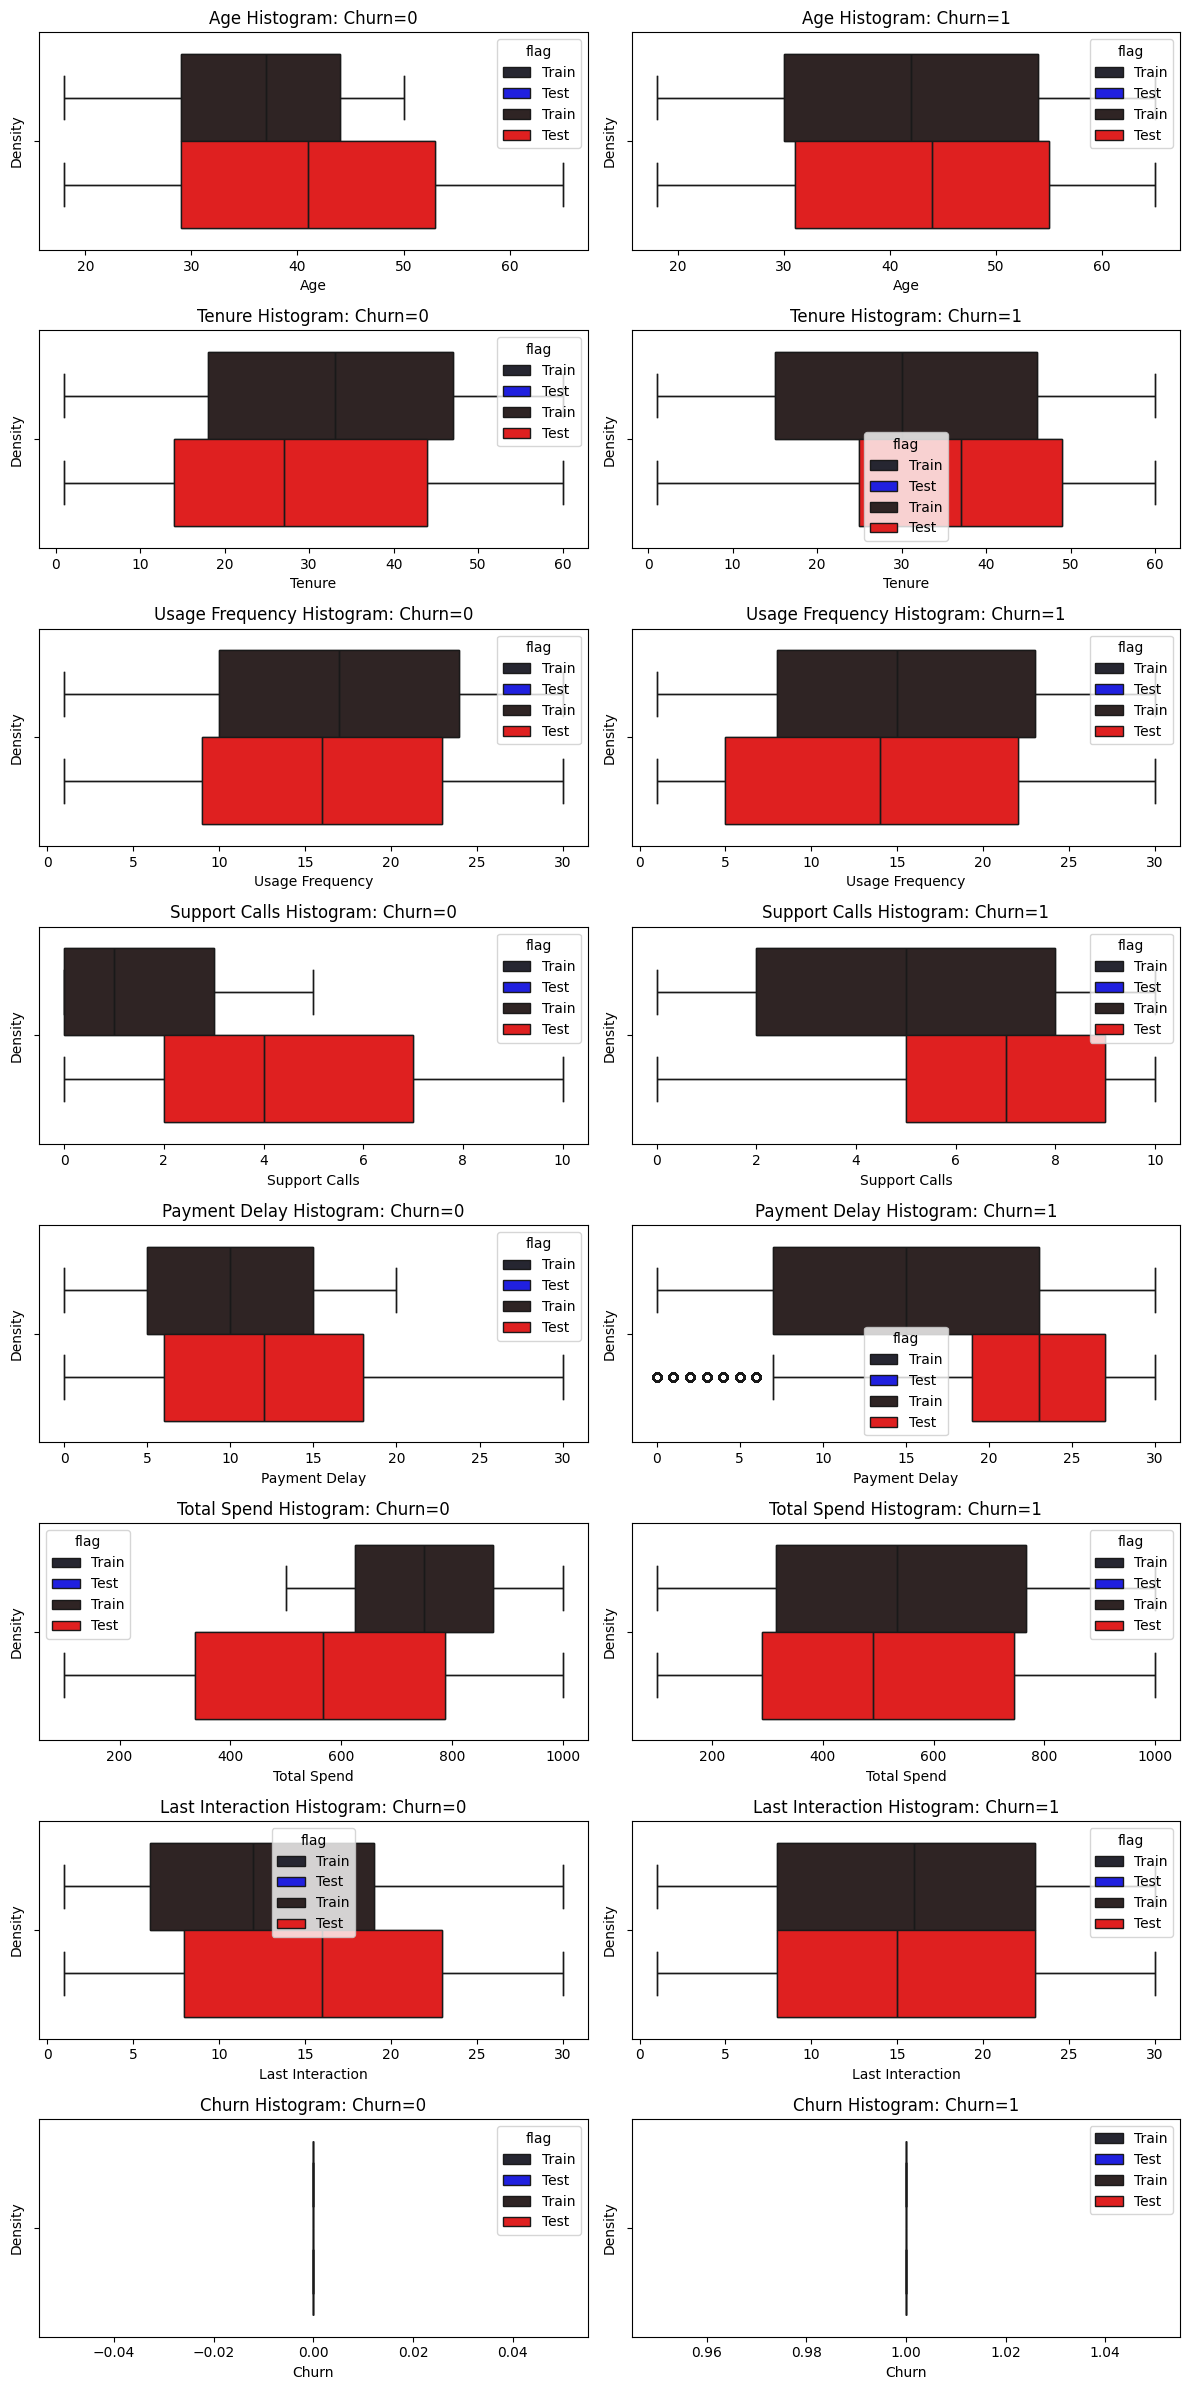

In [17]:
# checking for drift in the train and test data (whether the distribution of train and test data is different)
fig, axes = plt.subplots(len(numeric_cols), 2, figsize=(12, 3 * len(numeric_cols)))
train['flag'] = 'Train'
test['flag'] = 'Test'
merged_data = pd.concat([train, test], axis=0, ignore_index=True)
for i, col in enumerate(numeric_cols):
    # Histogram with KDE, Churn=0
    sns.boxplot(data=merged_data.loc[merged_data['Churn']==0], hue='flag', x=col, ax=axes[i, 0], color='blue')
    sns.boxplot(data=merged_data.loc[merged_data['Churn']==0], hue='flag', x=col, ax=axes[i, 0], color='red')
    axes[i, 0].set_title(f'{col} Histogram: Churn=0')
    axes[i, 0].set_xlabel(col)
    axes[i, 0].set_ylabel('Density')

    # Histogram with KDE, Churn=1
    sns.boxplot(data=merged_data.loc[merged_data['Churn']==1], hue='flag', x=col, ax=axes[i, 1], color='blue')
    sns.boxplot(data=merged_data.loc[merged_data['Churn']==1], hue='flag', x=col, ax=axes[i, 1], color='red')
    axes[i, 1].set_title(f'{col} Histogram: Churn=1')
    axes[i, 1].set_xlabel(col)
    axes[i, 1].set_ylabel('Density')

plt.tight_layout()
plt.legend()
plt.show()

train = train.drop(columns=['flag'])
test = test.drop(columns=['flag'])

Seems like there is a significant drift in the dataset. We will merge the dataset to remove the drift and perform splitting on the merged dataset

In [18]:
# creating the train and test datasets from merged data
raw_data = pd.concat([train, test], axis=0, ignore_index=True)
train, test = train_test_split(raw_data, test_size=0.2, random_state=42, stratify=raw_data['Churn'])

# separating x and y variables
xtrain = train.drop(columns=['Churn']).copy()
ytrain = train[['Churn']].copy()
xtest = test.drop(columns=['Churn']).copy()
ytest = test[['Churn']].copy()

# splitting the data
xtrain, xval, ytrain, yval = train_test_split(xtrain, ytrain, test_size=0.3, random_state=42, stratify=ytrain)

In [19]:
# encoding the categorical variables
encoder = category_encoders.TargetEncoder().fit(xtrain, ytrain)
xtrain = encoder.transform(xtrain)
xtest = encoder.transform(xtest)
xval = encoder.transform(xval)

In [20]:
# scaling the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(xtrain)
xtrain = scaler.transform(xtrain)
xtest = scaler.transform(xtest)
xval = scaler.transform(xval)

In [22]:
# saving the datasets as pickle files for later use
if not os.path.exists('data/cleaned'):
    os.makedirs('data/cleaned', exist_ok=True)
with open('data/cleaned/xtrain.pkl','wb') as f:
    pickle.dump(xtrain, f)
with open('data/cleaned/ytrain.pkl','wb') as f:
    pickle.dump(ytrain, f)
with open('data/cleaned/xtest.pkl','wb') as f:
    pickle.dump(xtest, f)
with open('data/cleaned/ytest.pkl','wb') as f:
    pickle.dump(ytest, f)
with open('data/cleaned/xval.pkl','wb') as f:
    pickle.dump(xval, f)
with open('data/cleaned/yval.pkl','wb') as f:
    pickle.dump(yval, f)